In [1]:
import sys
sys.path.append('..')

In [2]:
from helpers import *

In [1]:
import statsmodels.api as stats
from sklearn.decomposition import PCA

In [5]:
spy = stock_prices('SPY')

In [6]:
df = stock_prices('ADBE')


In [7]:
spy_ac_dt = spy.pct_change().adj_close
    #  dont use this smoothing, as is sort of cheating in the model # .rolling(window=40, win_type='gaussian', center=True).mean(std=20)

In [8]:
pct_ch = df.pct_change()
adj_close_dt = pct_ch.adj_close

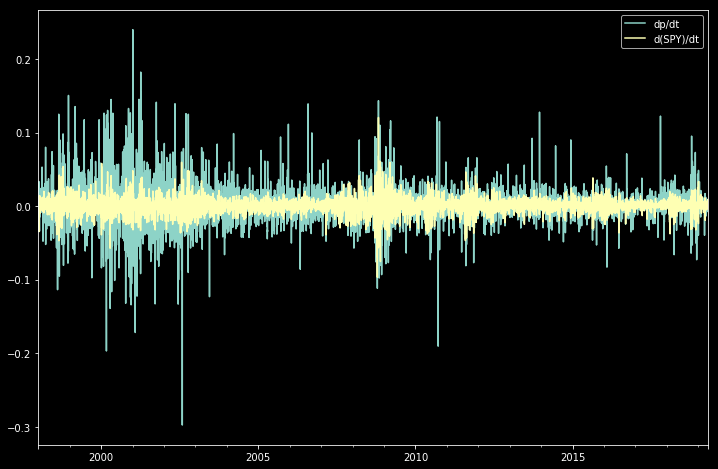

In [29]:

pd.concat([adj_close_dt.rename("dp/dt"),spy_ac_dt.rename("d(SPY)/dt")], axis=1).plot(figsize=(12,8))


### Model dp/dt with difference from d(SPY)/dt

In [11]:
diff = spy_ac_dt - adj_close_dt
X = left_windows(diff.dropna(),30)
X['y'] = pct_ch.adj_close
y = X.pop('y')
results = stats.OLS(y.values,X.values).fit()

In [21]:
print(results.summary().tables[0])
print(results.summary().tables[2])

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.006
Model:                            OLS   Adj. R-squared:                  0.002
Method:                 Least Squares   F-statistic:                     1.628
Date:                Sat, 27 Apr 2019   Prob (F-statistic):             0.0166
Time:                        13:02:46   Log-Likelihood:                 18665.
No. Observations:                7745   AIC:                        -3.727e+04
Df Residuals:                    7715   BIC:                        -3.706e+04
Df Model:                          30                                         
Covariance Type:            nonrobust                                         
Omnibus:                     1863.738   Durbin-Watson:                   1.993
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            94525.218
Skew:                           0.267   Prob(JB):   

In [22]:

# separate positive and negative index
X['y'] = y
pXi = X[X['y'] > 0].index
nXi = X[X['y'] < 0].index
X.pop('y')

# do pca
pca = PCA(n_components=2)
Xp = pd.DataFrame(pca.fit_transform(X),index = X.index)


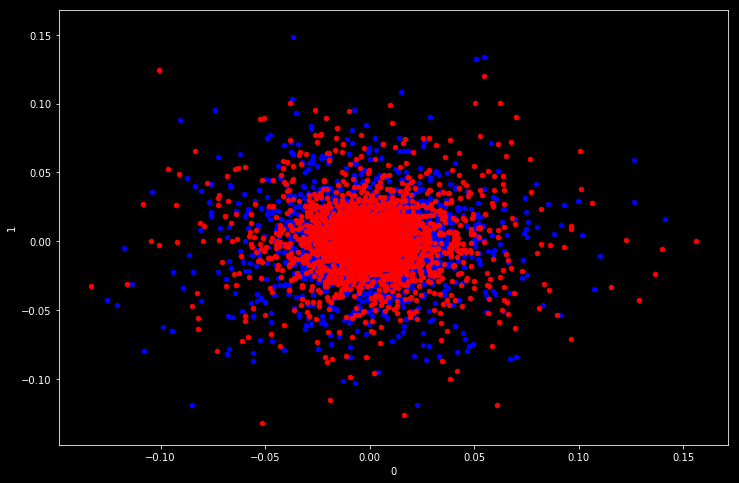

In [25]:
# plot pca positive vs negative day changes
ax = Xp.loc[pXi].plot.scatter(x=0,y=1,c='b',figsize=(12,8))
Xp.loc[nXi].plot.scatter(x=0,y=1,c='r',ax=ax)

### Model with mean and variance

In [30]:
X = left_windows(pct_ch.adj_close, 30)

In [34]:
mean,variance = X.apply(np.mean, axis=1).rename('mean'), X.apply(lambda x: np.std(x)**2, axis=1).rename('variance')

In [35]:
Xh = pd.concat([mean,variance],axis=1)

In [41]:
Xh['y'] = pct_ch.adj_close

In [42]:
pXi,nXi = Xh[Xh['y']>0].index, Xh[Xh['y']<0].index
y = Xh.pop('y')

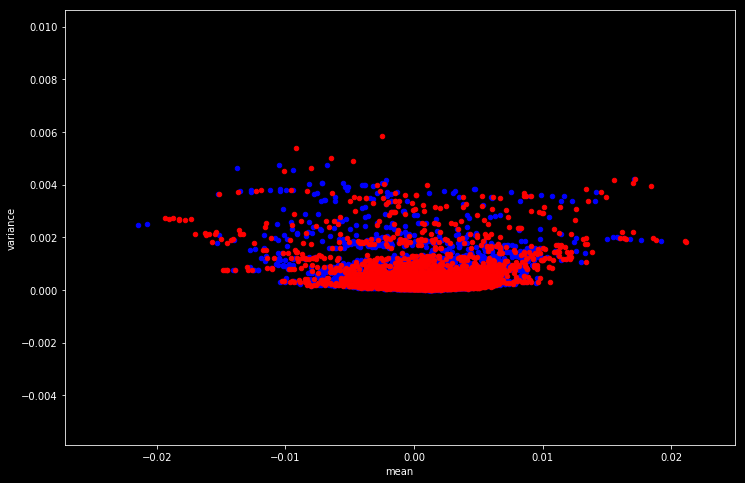

In [43]:
ax = Xh.loc[pXi].plot.scatter(x='mean',y='variance',c='b',figsize=(12,8))
Xh.loc[nXi].plot.scatter(x='mean',y='variance',c='r',ax=ax)

In [45]:
results = stats.OLS(y.values,Xh.values).fit()

In [46]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     4.496
Date:                Sat, 27 Apr 2019   Prob (F-statistic):             0.0112
Time:                        13:15:26   Log-Likelihood:                 18648.
No. Observations:                7746   AIC:                        -3.729e+04
Df Residuals:                    7744   BIC:                        -3.728e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -0.1081      0.066     -1.643      0.100      -0.237       0.021
x2             0.8158      0.311      2.624      0.009       0.206       1.425
==============================================================================
Omnibus:                     1826.129   Durbin-Watson:                   2.016
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            95493.455
Skew:                           0.193   Prob(JB):                         0.00
Kurtosis:                      20.197   Cond. No.                         4.74
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

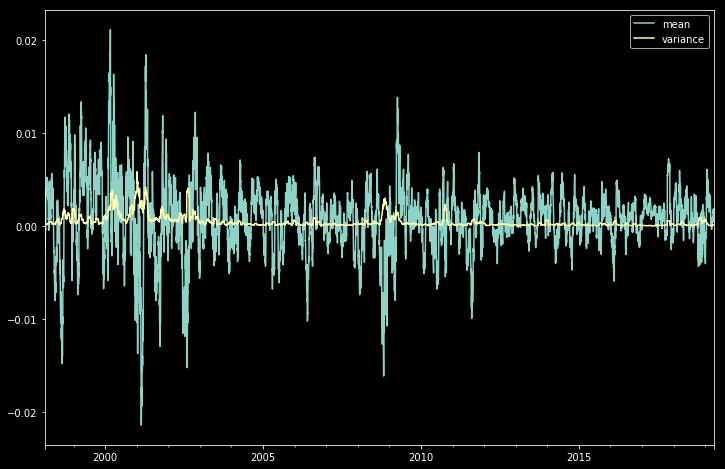

In [47]:
Xh.plot(figsize=(12,8))